In [1]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tqdm.keras import TqdmCallback
from keras_tqdm import TQDMCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import shutil

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
try:
    __IPYTHON__
except NameError:
    # Not in IPython.
    ipython = False
else:
    # In IPython.
    ipython = True

In [3]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../packages/")
from TsIP.TsIP import TsIP
from rolling_window import rolling_window
from tools import find_multiple_sets
from LagsCreator.LagsCreator import LagsCreator

In [4]:
# Create workspace.
dir = "./output"
if not os.path.exists(dir):
    os.makedirs(dir)
else:
    shutil.rmtree(dir)           
    os.makedirs(dir)

## Dataset

In [5]:
COUNTRIES = ["Yemen", "Syria"]

In [6]:
PATH_TO_DATA_FOLDER = lambda x: "../../Dataset time-series/data/" + x + "/"

In [7]:
trains = list()
tests = list()
targets = list()
for country in COUNTRIES:
    # Load the dataset of the training sets.
    train = pd.read_csv(PATH_TO_DATA_FOLDER(country) + "train_smooth.csv", header = [0, 1], index_col = 0)
    train.index.name = "Datetime"
    train.index = pd.to_datetime(train.index)
    freq = "D"
    train.index.freq = freq
    train.columns = pd.MultiIndex.from_tuples(map(lambda x: (country, x[0], x[1]), train.columns))
    trains.append(train)
    # Load the dataset of the test sets.
    test = pd.read_csv(PATH_TO_DATA_FOLDER(country) + "test_target.csv", header = [0, 1], index_col = 0)
    test.index.name = "Datetime"
    test.index = pd.to_datetime(test.index)
    freq = "D"
    test.index.freq = freq
    test.columns = pd.MultiIndex.from_tuples(map(lambda x: (country, x[0], x[1]), test.columns))
    tests.append(test)
    # Load the dataset of the whole time-series of the fcs indicator.
    target = pd.read_csv(PATH_TO_DATA_FOLDER(country) + "all_target.csv", header = [0, 1], index_col = 0)
    target.index.name = "Datetime"
    target.index = pd.to_datetime(target.index)
    freq = "D"
    target.index.freq = freq
    target.columns = pd.MultiIndex.from_tuples(map(lambda x: (country, x[0], x[1]), target.columns))
    targets.append(target)

In [8]:
train = pd.concat(trains, axis = 1)
train.columns.rename("Country", level = 0, inplace = True)
train.columns.rename("AdminStrata", level = 1, inplace = True)
train.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
train.index.freq = freq
train.dropna(axis = 0, how = "all", inplace = True)

In [9]:
test = pd.concat(tests, axis = 1)
test.columns.rename("Country", level = 0, inplace = True)
test.columns.rename("AdminStrata", level = 1, inplace = True)
test.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
test.index.freq = freq

In [10]:
target = pd.concat(targets, axis = 1)
target.columns.rename("Country", level = 0, inplace = True)
target.columns.rename("AdminStrata", level = 1, inplace = True)
target.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
target.index.freq = freq

In [11]:
TEST_SIZE = 30
FREQ = train.index.freq

In [12]:
TRAIN = train.copy()

## Data source transformation

I decide to normalize the data among the provinces considering indicator by indicator and considering only the training sets.

In [13]:
global SCALERS

MIN = 0
MAX = 1
SCALERS = dict()
def normalization(group, feature_range):
    min_, max_ = feature_range
    min_group = group.min().min()
    max_group = group.max().max()
    
    # Normalization.
    group_std = (group - min_group) / (max_group - min_group)
    group_scaled = group_std * (max_ - min_) + min_

    # Save the scalers for the various indicators.
    SCALERS[group.name] = (min_group, max_group)

    return group_scaled

In [14]:
TRAIN_NORMALIZED = TRAIN.groupby(axis = 1, level = [0, 2]).apply(lambda x: normalization(x, (MIN, MAX)))
TRAIN_NORMALIZED.tail()

Country                            Yemen                                \
AdminStrata                        Abyan                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2020-05-27                           NaN                           NaN   
2020-05-28                           NaN                           NaN   
2020-05-29                           NaN                           NaN   
2020-05-30                           NaN                           NaN   
2020-05-31                           NaN                           NaN   

Country                                                                      \
AdminStrata                                                                   
Indicator   Cereals and tubers Exchange rate (USD/LCU) FCS Fatality Lat Lon   
Datetime                                                                      
2020-05-27                 NaN                     NaN NaN      NaN NaN NaN   
2020-05-28                 NaN                     NaN NaN      NaN NaN NaN   
2020-05-29                 NaN                     NaN NaN      NaN NaN NaN   
2020-05-30                 NaN                     NaN NaN      NaN NaN NaN   
2020-05-31                 NaN                     NaN NaN      NaN NaN NaN   

Country                              ...                   Syria            \
AdminStrata                          ...                 Tartous             
Indicator   NDVI Anomaly Population  ... Exchange rate (USD/LCU)       FCS   
Datetime                             ...                                     
2020-05-27           NaN        NaN  ...                0.765620  0.573378   
2020-05-28           NaN        NaN  ...                0.773029  0.558735   
2020-05-29           NaN        NaN  ...                0.780438  0.539252   
2020-05-30           NaN        NaN  ...                0.787847  0.522278   
2020-05-31           NaN        NaN  ...                0.795255  0.520735   

Country                                                            \
AdminStrata                                                         
Indicator    Fatality       Lat       Lon NDVI Anomaly Population   
Datetime                                                            
2020-05-27   0.002560  0.590679  0.010535     0.221326   0.130932   
2020-05-28   0.002495  0.590679  0.010535     0.221774   0.130932   
2020-05-29   0.002413  0.590679  0.010535     0.222255   0.130932   
2020-05-30   0.002388  0.590679  0.010535     0.222751   0.130932   
2020-05-31   0.002553  0.590679  0.010535     0.223230   0.130932   

Country                                        
AdminStrata                                    
Indicator   Rainfall (mm)   Ramadan      rCSI  
Datetime                                       
2020-05-27       0.043537  0.870968  0.645364  
2020-05-28       0.042798  0.838710  0.645968  
2020-05-29       0.041891  0.806452  0.642337  
2020-05-30       0.040925  0.774194  0.627100  
2020-05-31       0.040214  0.741935  0.588556  

[5 rows x 390 columns]

In [15]:
# Plot time-series.
TsIP(TRAIN_NORMALIZED).interactive_plot_df(title = "Training sets", matplotlib = False, style = "lines", 
                                           first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [16]:
def denormalization(group_scaled, country, indicator, feature_range, scalers):
    min_, max_ = feature_range
    min_group, max_group = scalers[(country, indicator)]

    group_std = (group_scaled - min_) / (max_ - min_)
    group = (group_std * (max_group - min_group)) + min_group
    
    return group

In [17]:
# Get the training and test sets.
#TRAIN_NORMALIZED_SETS = find_multiple_sets(TRAIN_NORMALIZED)
#TEST_TARGET_SETS = find_multiple_sets(test)

## Training

In [18]:
LAGS = 7

In [19]:
lags_dict = dict()
# Define lags for each indicator.
lags_dict["3 Months Anomaly (%) Rainfall"] = LAGS
lags_dict["1 Month Anomaly (%) Rainfall"] = LAGS
lags_dict["Cereals and tubers"] = LAGS
lags_dict["Exchange rate (USD/LCU)"] = LAGS
lags_dict["FCS"] = LAGS
lags_dict["Fatality"] = LAGS
lags_dict["NDVI Anomaly"] = LAGS
lags_dict["Rainfall (mm)"] = LAGS
lags_dict["rCSI"] = LAGS
lags_dict["Lat"] = LAGS
lags_dict["Lon"] = LAGS
lags_dict["Population"] = LAGS
lags_dict["Ramadan"] = LAGS

In [20]:
X_train_list, y_train_list = list(), list()
X_test_dict = dict() 
for COUNTRY in COUNTRIES:
    dataframe = TRAIN_NORMALIZED[COUNTRY]
    # Adjust time-series group.
    first_idx = dataframe.first_valid_index()
    last_idx = dataframe.last_valid_index()
    dataframe = dataframe.loc[first_idx:last_idx]
    PROVINCES = dataframe.columns.get_level_values(0).unique()
    PREDICTORS = dataframe.columns.get_level_values(1).unique()    
    TRAIN_NORMALIZED_SETS = find_multiple_sets(dataframe)   
    for i, train_normalized in enumerate(TRAIN_NORMALIZED_SETS):
        # Create training points from the training set.
        for PROVINCE in PROVINCES:
            # Initialize lags creator.
            creator = LagsCreator(train_normalized[[PROVINCE]], lags_dictionary = lags_dict, target = "FCS")
            # Get samples.
            X_train, y_train, _, _, X_test = creator.to_supervised(n_out = TEST_SIZE, single_step = False, return_dataframe = False, 
                                                                   feature_time = False, validation = False, dtype = np.float32)

            # Add a list of all the training samples of all the provinces together.
            X_train_list.append(X_train)
            y_train_list.append(y_train)

            # Add the test sample of the province of the current set into a dictionary.
            X_test_dict[(PROVINCE, i)] = X_test

# Merge all the provinces. (n_samples, time-steps, n_features)
X_train = np.concatenate(X_train_list)
# Merge all the provinces. (n_samples, n_out)
y_train = np.concatenate(y_train_list)

print("Training shape: X:", X_train.shape, "y:", y_train.shape)

Training shape: X: (13120, 7, 13) y: (13120, 30)


In [21]:
N_FEATURES = X_train.shape[2]

In [22]:
def network(timesteps, features, n_out):      
    model = Sequential()

    # MODEL.
    #model.add(LSTM(128, return_sequences = True, batch_input_shape = (None, timesteps, features)))
    model.add(LSTM(10, return_sequences = False, batch_input_shape = (None, timesteps, features)))

    model.add(Dense(n_out))  

    return model

In [23]:
N_EPOCHS = 500
BATCH_SIZE = 128

Training the network:


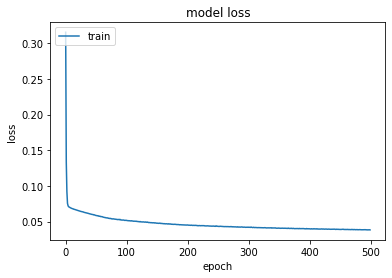

In [24]:
model = network(LAGS, N_FEATURES, TEST_SIZE)
# Compile model.
model.compile(loss = "mse", optimizer = "adam")
# Fit model.
print("Training the network:")
if ipython:
    history = model.fit(X_train, y_train, epochs = N_EPOCHS, batch_size = BATCH_SIZE, verbose = 0, shuffle = True, 
                        callbacks = [TqdmCallback(verbose = 1)])
else:
    history = model.fit(X_train, y_train, epochs = N_EPOCHS, batch_size = BATCH_SIZE, verbose = 0, shuffle = True, 
                        callbacks = [TQDMCallback(outer_description = "Loading:", leave_inner = False, leave_outer = False)])

# Plot result of the training and validation.
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train"], loc = "upper left")
plt.show()

In [25]:
TEST_TARGET_SETS = find_multiple_sets(test["Yemen"])

In [26]:
FORECASTING_NORMALIZED = test["Yemen"].copy()
# Prediction over the test sets.
for i, test_set in enumerate(TEST_TARGET_SETS):
    # Prediction for each province.
    for PROVINCE in train["Yemen"].columns.get_level_values(0).unique():
        X_test = X_test_dict[(PROVINCE, i)]
        # Prediction.
        y_hats = model.predict(X_test, verbose = 0).flatten() 
        # Add the prediction to the dataframe.
        FORECASTING_NORMALIZED[(PROVINCE, "FCS")].loc[test_set.index] = y_hats

In [27]:
# Denormalization.
FORECASTING = denormalization(FORECASTING_NORMALIZED, "Yemen", "FCS", (MIN, MAX), SCALERS)

In [28]:
# Plot time-series.
TsIP(FORECASTING, target["Yemen"]).interactive_plot_df(title = "Forecasting", matplotlib = False, style = "lines", comparison = True)

interactive(children=(RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Ti…

In [29]:
FORECASTING_TARGET_SETS = find_multiple_sets(FORECASTING)

In [30]:
from sklearn.metrics import mean_squared_error

# Loss.
losses = list()
losses_h = list()
for test_set, forecasting_set in zip(TEST_TARGET_SETS, FORECASTING_TARGET_SETS):
    loss = mean_squared_error(test_set, forecasting_set)
    losses.append(loss)
    loss_h = mean_squared_error(test_set.transpose(), forecasting_set.transpose(), multioutput = "raw_values")    
    losses_h.append(loss_h)

In [31]:
np.mean(losses)

50.93981350875884

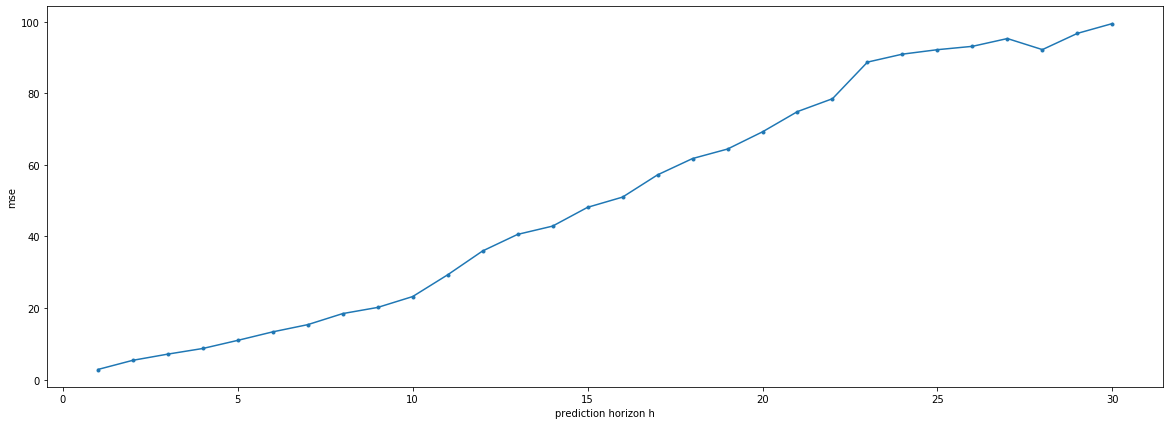

In [32]:
fig, ax = plt.subplots(figsize = (20, 7))
ax.plot(np.arange(1, TEST_SIZE + 1), np.mean(losses_h, axis = 0), ".-")
ax.set_ylabel("mse", fontsize = 10)
ax.set_xlabel("prediction horizon h", fontsize = 10);